In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())

Data Loading and Cleaning

In [2]:
def process_data():
    ## quaterly data, already the gdp growth forecast
    #gdpNow = pd.read_csv('./data/GDPNOW_2011_2022.csv').rename(
    #        columns = {'DATE':'date','GDPNOW':'gdp now'}
    #        )
    #gdpNow['date'] = pd.to_datetime(gdpNow['date'])
    #gdpNow.sort_values('date',inplace=True)

    gdp = pd.read_excel('./data/GDPC1.xls',skiprows=10)
    gdp.columns = ['date','gdp']
    gdp['date'] = pd.to_datetime(gdp['date'])
    gdp.sort_values('date',inplace=True)
    gdp['gdp growth'] = gdp['gdp'].pct_change(4)
    del gdp['gdp']

    ## monthly spotprice
    InflationRate = pd.read_csv('./data/1yrExpectedInflationRate.csv').rename(
    columns={'DATE':'date','EXPINF1YR':'IR'})
    InflationRate['date'] = pd.to_datetime(InflationRate['date'])
    InflationRate.sort_values('date',inplace=True)
    InflationRate['IR_y2y_ratio'] = InflationRate['IR'].pct_change(12)

    CPI = pd.read_csv('./data/cpi.csv').rename(columns={'DATE':'date','CPIAUCSL':'CPI'})
    CPI['date'] = pd.to_datetime(CPI['date'])
    CPI.sort_values('date',inplace=True)
    CPI['CPI_y2y_ratio'] = CPI['CPI'].pct_change(12)

    pmi = pd.read_csv('./data/ISM-MAN_PMI.csv').sort_values('Date').rename(
            columns = {'Date':'date','PMI':'PMI'}
        )
    pmi['date'] = pd.to_datetime(pmi['date'])
    pmi.sort_values('date',inplace=True)
    pmi['pmi_y2y_ratio'] = pmi['PMI'].pct_change(12)

    ## weekly data
    nfci = pd.read_csv('./data/NFCI_1971_2022.csv').rename(
            columns = {'DATE':'date','NFCI':'NFCI'}
        )
    nfci['date'] = pd.to_datetime(nfci['date'])
    nfci.sort_values('date',inplace=True)

    Inventory = pd.read_csv('./data/Inventory.csv',skiprows=4).rename(
    columns = {
        'Week of':'date','Weekly U.S. Ending Stocks of Crude Oil and Petroleum Products Thousand Barrels':'Inventory'})
    Inventory['date'] = pd.to_datetime(Inventory['date'])
    Inventory.sort_values('date',inplace=True)
    Inventory['Inventory_y2y_ratio'] = Inventory['Inventory'].pct_change(12)
    Inventory['Inventory_mom_3_12'] = Inventory['Inventory'].rolling(3).mean() - Inventory['Inventory'].rolling(12).mean() 
    ## daily data
    USDIndex = pd.read_csv('./data/usd_index.csv')[['Date','Adj Close']].rename(
        columns = {'Date':'date','Adj Close':'USD'}
    )
    USDIndex['date'] = pd.to_datetime(USDIndex['date'])
    USDIndex.sort_values('date',inplace=True)
    USDIndex.dropna(inplace=True)
    USDIndex['usd_mom_20_125'] = USDIndex['USD'].rolling(20).mean() - USDIndex['USD'].rolling(125).mean()

    VIX = pd.read_csv('./data/VIX.csv').rename(
                columns = {'DATE':'date','VIXCLS':'VIX'}
            )
    VIX.drop(VIX[VIX['VIX'] == '.'].index, inplace=True)
    VIX['date'] = pd.to_datetime(VIX['date'])
    VIX['VIX'] = pd.to_numeric(VIX['VIX'])
    VIX.sort_values('date',inplace=True)

    wti = pd.read_excel('./data/PET_PRI_FUT_S1_D.xls', sheet_name=1,skiprows=2)
    wti.columns = ['date','F1','F2','F3','F4']
    wti['date'] = pd.to_datetime(wti['date'])
    wti = wti[wti['date']>=pd.Timestamp('20051201')]
    wti.sort_values('date',inplace=True)
    wti['dollar_ret'] = wti['F1'].diff()
    wti['dollar_vol_monthly'] = wti['dollar_ret'].rolling(20).std() * np.sqrt(252/20)
    wti['carry'] = wti['F1'] - wti['F4']
    wti['carry_mom_1_5'] = wti['carry'] - wti['carry'].rolling(5).mean()
    wti['carry_mom_5_20'] = wti['carry'].rolling(5).mean() - wti['carry'].rolling(20).mean()
    wti['carry_mom_20_125'] = wti['carry'].rolling(20).mean() - wti['carry'].rolling(125).mean()

    spotprice = pd.read_excel('./data/WTIprice.xls',skiprows=10)
    spotprice.columns = ['date','F1']
    spotprice['date'] = pd.to_datetime(spotprice['date'])
    spotprice.sort_values('date',inplace=True)
    spotprice['mom_1_5'] = spotprice['F1'] - spotprice['F1'].rolling(5,closed = 'both').mean()
    spotprice['mom_5_20'] = spotprice['F1'].rolling(5,closed = 'both').mean() - spotprice['F1'].rolling(20,closed = 'both').mean()
    spotprice['mom_20_250'] = spotprice['F1'].rolling(20,closed = 'both').mean() - spotprice['F1'].rolling(250,closed = 'both').mean()
    del spotprice['F1']
    ## merge data
    monthy_data = InflationRate.merge(CPI, how='outer').merge(pmi, how='outer')\
                .sort_values('date')
    #monthy_data = monthy_data[monthy_data['date']>=pd.Timestamp('20051201')]
    monthy_data.set_index('date',inplace=True)

    weekly_data = nfci.merge(Inventory, how='outer')\
                .sort_values('date')
    #weekly_data = weekly_data[weekly_data['date']>=pd.Timestamp('20051201')]
    weekly_data.set_index('date',inplace=True)

    daily_data = USDIndex.merge(wti,how='outer').merge(VIX, how='outer').merge(spotprice,how='outer').sort_values('date')
    #daily_data = daily_data[daily_data['date']>=pd.Timestamp('20051201')]
    daily_data.set_index('date',inplace=True)

    quaterly_data = gdp.sort_values('date')
    #quaterly_data = quaterly_data[quaterly_data['date']>=pd.Timestamp('20051201')]
    quaterly_data.set_index('date',inplace = True)

    ## forward data filling
    data = pd.concat([quaterly_data,monthy_data,
                             weekly_data,daily_data],axis=1)
    data.dropna(how='all', inplace=True)
    data.fillna(method='ffill', inplace=True)
    data.dropna(how='all',axis=0, subset = ['F1','F2','F3','F4'], inplace = True)
    data = data[data.index>=pd.Timestamp('20051201')]
    #data = data[[i for i in data.columns if not i in ['CPI','F1','F2','F3','F4','Inventory']]]
    return data

In [3]:
data = process_data()
data = data.dropna(how='any')

Feature selection

Part I: Macro features excluded (but with some technical signal constructed from macro signal, e.g. USD momentum, Inventory momentum, etc.)

In [4]:
features_name_macro_exluded = [i for i in data.columns if not i in ['F1','F2','F3','F4','Inventory',
                'PMI','NFCI','CPI','IR','gdp growth','USD']]

In [5]:
from Sparse_jump import *
from sklearn.preprocessing import StandardScaler

In [6]:
data_selected = data[features_name_macro_exluded]

Here we can see the differnet feature weights.

<AxesSubplot:>

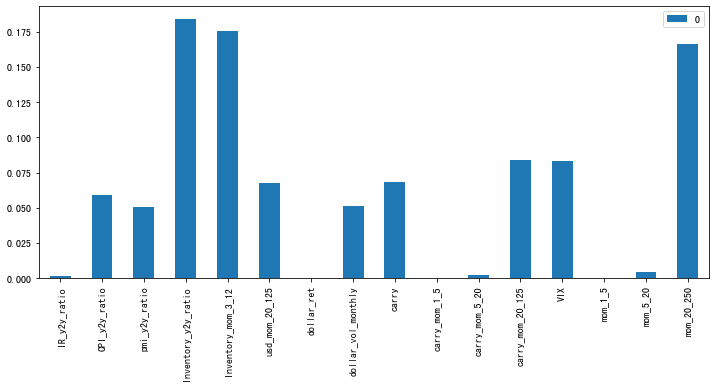

In [7]:
scaler = StandardScaler()
dt = scaler.fit_transform(data_selected)
states, feature_weights = sparse_jump(dt, n_states=3, max_features=20,jump_penalty=1)
pd.DataFrame(feature_weights/sum(feature_weights), index = data_selected.columns).plot(kind='bar', figsize=(12,5))

In [8]:
data_selected['states'] = states

/var/folders/dp/j1mh4_sn5zzbjcwlmx7473z80000gn/T/ipykernel_67331/2893791920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['states'] = states


In [9]:
important_features = data_selected.columns[np.where(feature_weights>=0.025)]
summary_table_macro_excluded = data_selected[important_features.to_list()+['states']].groupby('states').mean()\
                                .sort_values('mom_20_250').T
#print(summary_table_macro_excluded)

In [10]:
# we make an order for the states, bull +1, bear -1, static 0
print('original states(ordered by mom_20_250 signal) is: {}'.format(summary_table_macro_excluded.columns.tolist()))
print('The meaningful states should be: [-1, 0, 1]')
states_map = dict(zip(summary_table_macro_excluded.columns.tolist(), [-1,0,1]))
print(states_map)
data_selected['True_state'] = data_selected['states'].apply(lambda x: states_map[x])

original states(ordered by mom_20_250 signal) is: [0, 1, 2]
The meaningful states should be: [-1, 0, 1]
{0: -1, 1: 0, 2: 1}


/var/folders/dp/j1mh4_sn5zzbjcwlmx7473z80000gn/T/ipykernel_67331/2268163013.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['True_state'] = data_selected['states'].apply(lambda x: states_map[x])


In [11]:
summary_table_macro_excluded = data_selected[important_features.to_list()+['True_state']].groupby('True_state').mean().T
print(summary_table_macro_excluded)

True_state                     -1             0             1
CPI_y2y_ratio            0.002401      0.017344      0.027494
pmi_y2y_ratio           -0.167861     -0.011182      0.072786
Inventory_y2y_ratio      0.023085      0.017070     -0.017856
Inventory_mom_3_12   19142.289232  12076.513977 -13593.268065
usd_mom_20_125           3.801640      0.154226     -0.515486
dollar_vol_monthly      11.921783      4.582248      4.930358
carry                   -4.950714     -1.017261     -0.168115
carry_mom_20_125        -2.774352      0.245084      0.316754
VIX                     37.251526     17.958710     18.730121
mom_20_250             -36.935364     -0.115520      6.611047


In [17]:
#features = data_selected[important_features.to_list()+['carry_mom_1_5','carry_mom_5_20','mom_1_5','mom_5_20']]
#features.to_hdf('./features/features_data.h5','abc')
features = data_selected[important_features.to_list()]
features.to_hdf('./features/features_data.h5','abc')
pd.to_pickle(feature_weights[np.where(feature_weights>=0.025)],'./features/features_weights')

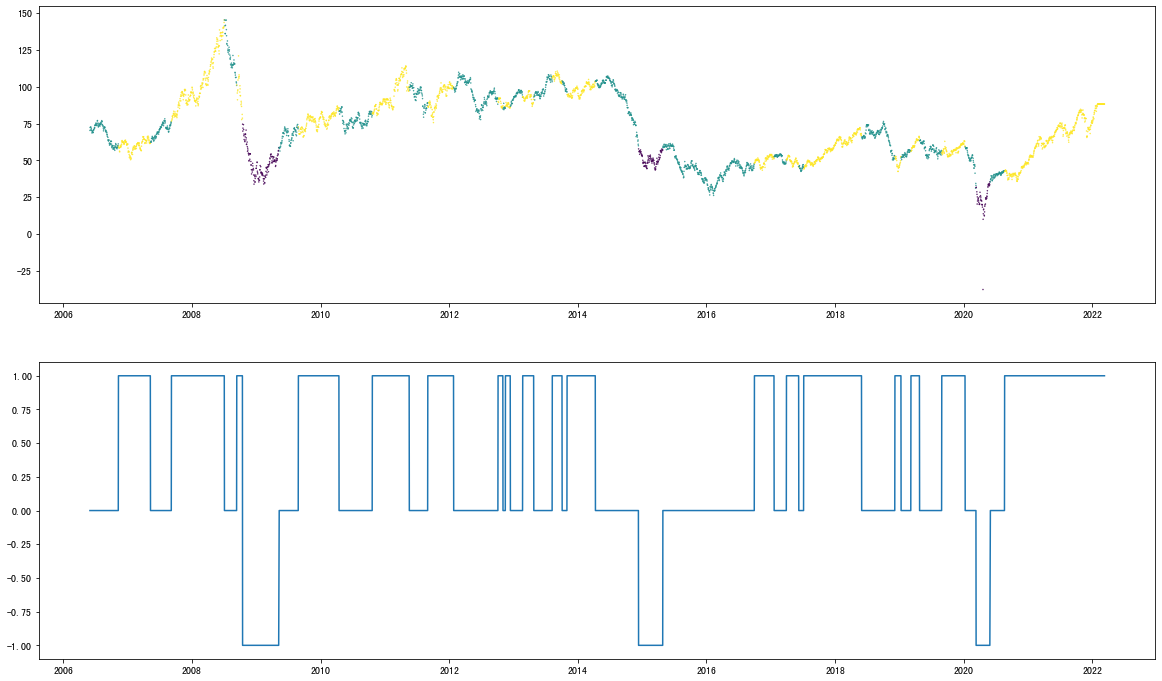

In [16]:
fig, axes = plt.subplots(ncols=1,nrows=2, sharex=False,figsize=(20,12))
axes[0].scatter(data.index.to_list(),data['F1'],c=data_selected['True_state'].values, s = 0.2)
axes[1].plot(data.index.to_list(),data_selected['True_state'].values)

Part II: macro features included

In [13]:
features_name_macro_included = [i for i in data.columns if not i in ['F1','F2','F3','F4']]

In [14]:
data_selected = data[features_name_macro_included]

<AxesSubplot:>

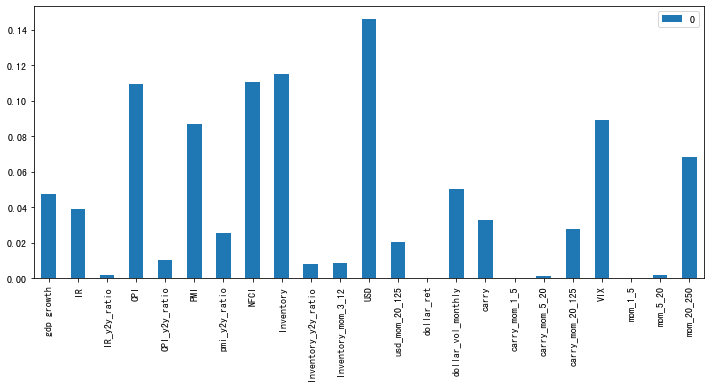

In [15]:
scaler = StandardScaler()
dt = scaler.fit_transform(data_selected)
states, feature_weights = sparse_jump(dt, n_states=3, max_features=20,jump_penalty=1)
pd.DataFrame(feature_weights/sum(feature_weights), index = data_selected.columns).plot(kind='bar', figsize=(12,5))

In [16]:
data_selected['states'] = states

/var/folders/dp/j1mh4_sn5zzbjcwlmx7473z80000gn/T/ipykernel_64043/2893791920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['states'] = states


In [17]:
important_features = data_selected.columns[np.where(feature_weights>=0.045)]
summary_table_macro_excluded = data_selected[important_features.to_list()+['states']].groupby('states').mean()\
                                .sort_values('mom_20_250').T
#print(summary_table_macro_excluded)

In [18]:
# we make an order for the states, bull +1, bear -1, static 0
print('original states(ordered by mom_20_250 signal) is: {}'.format(summary_table_macro_excluded.columns.tolist()))
print('The meaningful states should be: [-1, 0, 1]')
states_map = dict(zip(summary_table_macro_excluded.columns.tolist(), [-1,0,1]))
print(states_map)
data_selected['True_state'] = data_selected['states'].apply(lambda x: states_map[x])

original states(ordered by mom_20_250 signal) is: [2, 0, 1]
The meaningful states should be: [-1, 0, 1]
{2: -1, 0: 0, 1: 1}


/var/folders/dp/j1mh4_sn5zzbjcwlmx7473z80000gn/T/ipykernel_64043/2268163013.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['True_state'] = data_selected['states'].apply(lambda x: states_map[x])


In [19]:
summary_table_macro_excluded = data_selected[important_features.to_list()+['True_state']].groupby('True_state').mean().T
print(summary_table_macro_excluded)

True_state                    -1             0             1
gdp growth         -3.764213e-02  2.355713e-02  1.731108e-02
IR                  6.379196e-01  1.747062e+00  1.895958e+00
CPI                 2.220381e+02  2.516537e+02  2.214567e+02
PMI                 3.861938e+01  5.513678e+01  5.333739e+01
pmi_y2y_ratio      -2.314851e-01  2.312306e-02  3.906880e-02
NFCI                1.635630e+00 -5.280011e-01 -2.801871e-01
Inventory           1.769021e+06  1.936842e+06  1.745646e+06
USD                 8.755150e+01  9.534053e+01  7.991037e+01
usd_mom_20_125      2.882115e+00  3.528433e-01 -4.313860e-01
dollar_vol_monthly  1.501985e+01  4.132594e+00  5.282929e+00
carry              -5.377313e+00 -4.881770e-01 -7.951271e-01
carry_mom_20_125   -2.408509e+00  1.550170e-01  2.378314e-01
VIX                 4.703634e+01  1.725775e+01  1.903330e+01
mom_20_250         -3.557094e+01 -6.261919e-01  5.255447e+00


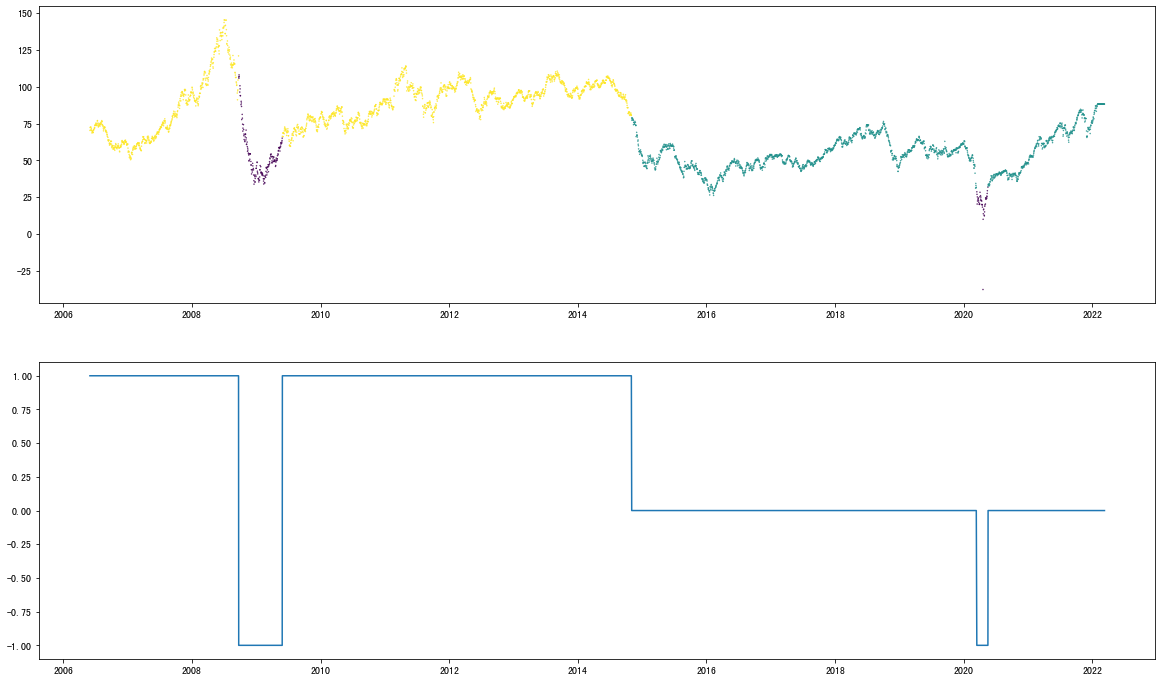

In [20]:
fig, axes = plt.subplots(ncols=1,nrows=2, sharex=False,figsize=(20,12))
axes[0].scatter(data.index.to_list(),data['F1'],c=data_selected['True_state'].values, s = 0.2)
axes[1].plot(data.index.to_list(),data_selected['True_state'].values)